In [2]:
import pandas as pd
import numpy as np
import ampal

In [3]:
def generate_deltaprot_designs_data():

    no_disulfide_df =pd.read_csv("/home/tadas/code/single_chain_dp_bristol/selected_deltaprots/no_disulfide/no_disulfide_selected_deltaprots.csv")
    variable_linkers_df = pd.read_csv("/home/tadas/code/single_chain_dp_bristol/selected_deltaprots/variable_linkers/variable_linkers/variable_linkers_selected_deltaprots.csv")

    no_disulfide_df["name"]="no_disulfide_"+no_disulfide_df["orientation_code"]
    variable_linkers_df["name"]="variable_linkers_"+variable_linkers_df["orientation_code"]

    # merge the two piplene dataframes 
    df = pd.concat([no_disulfide_df, variable_linkers_df], axis=0)

    well_df = pd.read_csv("/home/tadas/code/single_chain_dp_bristol/order_optimised_codons_96_wp.csv")

    # merge well_df with df by Name and sort by Well Position
    df = pd.merge(well_df, df, how="left", left_on="Name", right_on="name")

    # MGSSHHHHHHSSGENLYFQSGS addition adds some mw
    df["model_sequence_w_prefix"] = "MGSSHHHHHHSSGENLYFQSGS" + df["model_sequence"]
    df["mass_w_prefix"] = df["model_sequence_w_prefix"].apply(ampal.analyse_protein.sequence_molecular_weight)
    df["sequence_molar_extinction_280_w_prefix"] = df["model_sequence_w_prefix"].apply(ampal.analyse_protein.sequence_molar_extinction_280)
    df.to_csv("/home/tadas/code/single_chain_dp_bristol/deltaprot_designs_data.csv", index=False)

def load_deltaprot_designs_data():
    return pd.read_csv("/home/tadas/code/single_chain_dp_bristol/deltaprot_designs_data.csv")

def calc_molar_conc(ext_coef, absorbance):
    return ext_coef / absorbance

def calc_mg_per_ml(molar_conc, mass):
    return molar_conc * mass

In [4]:
generate_deltaprot_designs_data()
df = load_deltaprot_designs_data()


In [16]:

# populate received_from_idt column. Received everything except for C2,C4,D5,D6,F2,F3,F6


not_received = ['C2', 'C4', 'D5', 'D6', 'F2', 'F3', 'F6']
df['received_from_idt'] = ~df["Well Position"].isin(not_received)

# populate transformation_attempted for (A1-A12,B1-B12,C1,C3,F4,C5,C6)
transformation_attempted_ids = set([f"A{i}" for i in range(1, 13)] +
                    [f"B{i}" for i in range(1, 13)] +
                    ['C1', 'C3', 'F4', 'C5', 'C6'])
df['transformation_attempted'] = df["Well Position"].isin(transformation_attempted_ids)
df['transformation_successful'] = df["Well Position"].apply(
    lambda x: (False if x == 'C6' else True) if x in transformation_attempted_ids else np.nan
)

# populate tranformation_successful for transformation_attempted only (otherwise none), but false for C6
df['transformation_successful'] = df["Well Position"].apply(
    lambda x: (False if x == 'C6' else True) if x in transformation_attempted_ids else np.nan
)

# populate expression_levels: (None, "low","medium","high") low: A1,A3,A6,A7,A8,A10,B1. Medium: A5,A11,B2,B3. High: A9,A12
expr_map = {
    **dict.fromkeys(['A1','A3', 'A6', 'A8', 'B1','B4', 'B10','C3'], 'low'),
    **dict.fromkeys(['A7', 'A10','B12','C1','F4'], 'medium'),
    **dict.fromkeys(['A11', 'B2', 'B3','A5'], 'high'),
    **dict.fromkeys(['A9', 'A12', 'B8'], 'super_high')
}
df['expression_levels'] = df["Well Position"].map(expr_map)

# populate sds_page_size_appearance for every visible band?
# TODO

# populate large_scale_expressed for A12,A9,B8,A1,B12,F4
scaled_expressed_ids = ['A12','A9','B8','A1','B12','F4']
df['large_scale_expressed'] = df["Well Position"].isin(scaled_expressed_ids)

# populate scaled_purified for A12,A9,B8 TODO add ,'A1','B12','F4'
# scaled_purified_ids = ['A12','A9','B8'] \

# Note: A9,B8 had some aggregation (small pellet after spining down). A12 did not

A280_after_NI_NTA_IMAC = {
    "A12": 13.41,
    "A9": 6.2,
    "B8": 16.11
}


df['A280_after_NI_NTA_IMAC'] = df["Well Position"].map(A280_after_NI_NTA_IMAC)

# calculate molar conc asuming sample is entirely my protein df.sequence_molar_extinction_280

df['molar_conc_after_NI_NTA_IMAC'] = df['A280_after_NI_NTA_IMAC'] / df['sequence_molar_extinction_280_w_prefix']
df['mg_per_ml_after_NI_NTA_IMAC'] = df['molar_conc_after_NI_NTA_IMAC'] * df['mass_w_prefix']


# after SEC (central fractions)
A280_after_SEC = {
    "A12": 4.93,
    "A9": 2.18,
    "B8": 6.758,
}
volume_after_sec = {
    "A12": 5.1,
    "A9": 5.1,
    "B8": 3.4
}
df["volume_after_sec"] = df["Well Position"].map(volume_after_sec)

df['A280_after_SEC'] = df["Well Position"].map(A280_after_SEC)
df['molar_conc_after_SEC'] = df['A280_after_SEC'] / df['sequence_molar_extinction_280_w_prefix']
df['mg_per_ml_after_SEC'] = df['molar_conc_after_SEC'] * df['mass_w_prefix']
df['mg_after_SEC'] = df['mg_per_ml_after_SEC'] * df['volume_after_sec']


# Biophysical characterisation info (CD and biophysical SEC used same sample. Was assumed it is 20 uM, however it was a bit less.)
cd_sample_A280 = {
    "A12": 0.395, # later measure: 0.406
    "A9": 0.168, # later measure: 0.190
    "B8": 0.517, # later measure: 0.537
}
df["cd_sample_A280"] = df["Well Position"].map(cd_sample_A280)
df["cd_sample_molar_conc"] = df["cd_sample_A280"] / df["sequence_molar_extinction_280_w_prefix"]


In [6]:
# save df to csv
df.to_csv("/home/tadas/code/single_chain_dp_bristol/experimental_results/deltaprot_designs_data_with_results.csv", index=False)

In [7]:
df[["Well Position","Name","mass","mass_w_prefix","charge","A280_after_SEC","volume_after_sec","sequence_molar_extinction_280_w_prefix","molar_conc_after_NI_NTA_IMAC","molar_conc_after_SEC","mg_per_ml_after_SEC","mg_after_SEC"]]

,Well Position,Name,mass,mass_w_prefix,charge,A280_after_SEC,volume_after_sec,sequence_molar_extinction_280_w_prefix,molar_conc_after_NI_NTA_IMAC,molar_conc_after_SEC,mg_per_ml_after_SEC,mg_after_SEC
0,A1,no_disulfide_b3iii,7218.91718,9661.41738,-7.195539,NaN,NaN,10810,NaN,NaN,NaN,NaN
1,A2,no_disulfide_b3nnn,6293.89118,8736.39138,-3.196935,NaN,NaN,13940,NaN,NaN,NaN,NaN
2,A3,no_disulfide_b4iiiix,9399.48898,11841.98918,-8.306272,NaN,NaN,12090,NaN,NaN,NaN,NaN
3,A4,no_disulfide_b4iiiiy,7503.21198,9945.71218,-7.429897,NaN,NaN,23470,NaN,NaN,NaN,NaN
4,A5,no_disulfide_b4iiin,6905.64008,9348.14028,-9.196622,NaN,NaN,15220,NaN,NaN,NaN,NaN
5,A6,no_disulfide_b4inin,9720.64698,12163.14718,-20.303951,NaN,NaN,16500,NaN,NaN,NaN,NaN
6,A7,no_disulfide_b4innn,8302.30618,10744.80638,-8.256534,NaN,NaN,12660,NaN,NaN,NaN,NaN
7,A8,no_disulfide_b4nnnnx,8860.65328,11303.15348,-12.148349,NaN,NaN,19060,NaN,NaN,NaN,NaN
8,A9,no_disulfide_b4nnnny,8651.77758,11094.27778,-7.202815,2.180,5.1,12090,0.000513,0.000180,2.000457,10.202331
9,A10,no_disulfide_b5iiiin,9471.93758,11914.43778,-4.200798,NaN,NaN,13940,NaN,NaN,NaN,NaN


In [9]:
# mass correct: A9, A11, B2, C1, F4, B12
# mass questionable: A12 (has 2 bands), B3 (2 bands)
# mass wrong: 

In [10]:
# unlimit pandas column display number
pd.set_option('display.max_columns', None)

In [8]:
df[df["expression_levels"].isin(["low","medium","high","super_high"])].sort_values("expression_levels")[["Well Position","Name","mass_w_prefix","expression_levels"]]

,Well Position,Name,mass_w_prefix,expression_levels
4,A5,no_disulfide_b4iiin,9348.14028,high
10,A11,no_disulfide_b5iinin,14240.78108,high
13,B2,no_disulfide_b6iiniin,15364.04798,high
14,B3,no_disulfide_b6ininin,15691.18198,high
0,A1,no_disulfide_b3iii,9661.41738,low
2,A3,no_disulfide_b4iiiix,11841.98918,low
5,A6,no_disulfide_b4inin,12163.14718,low
7,A8,no_disulfide_b4nnnnx,11303.15348,low
21,B10,no_disulfide_l4iin,10960.05638,low
26,C3,no_disulfide_l5niin,12407.63028,low


In [14]:
x=df[df["expression_levels"].isin(["high","super_high"])]
x

,Well Position,Name,Sequence,orientation_code,atp_cost_per_aa,dna_complexity_per_aa,pll,pll_per_aa,isoelectric_point,charge,...,A280_after_NI_NTA_IMAC,molar_conc_after_NI_NTA_IMAC,mg_per_ml_after_NI_NTA_IMAC,volume_after_sec,A280_after_SEC,molar_conc_after_SEC,mg_per_ml_after_SEC,mg_after_SEC,cd_sample_A280,cd_sample_molar_conc
4,A5,no_disulfide_b4iiin,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b4iiin,22.315873,3.777778,-116.430898,-1.848109,3.9,-9.196622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A9,no_disulfide_b4nnnny,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b4nnnny,24.277465,3.352113,-120.195202,-1.692890,4.5,-7.202815,...,6.20,0.000513,5.689373,5.1,2.180,0.000180,2.000457,10.202331,0.168,0.000014
10,A11,no_disulfide_b5iinin,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b5iinin,24.250000,3.541667,-151.663192,-1.579825,4.3,-15.186800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,A12,no_disulfide_b5ininn,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b5ininn,25.084375,3.031250,-183.494775,-1.911404,5.0,-5.156637,...,13.41,0.000604,8.516672,5.1,4.930,0.000222,3.131036,15.968285,0.395,0.000018
13,B2,no_disulfide_b6iiniin,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b6iiniin,24.496330,3.256881,-188.486552,-1.729234,4.5,-9.212326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,B3,no_disulfide_b6ininin,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,b6ininin,25.733028,3.385321,-233.052069,-2.138092,4.3,-15.108405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,B8,no_disulfide_h6i_i_i,ATGGGCAGCAGCCATCATCATCATCATCACAGCAGCGGCGAGAACT...,h6i_i_i,25.288793,3.120690,-238.743973,-2.058138,4.6,-9.316016,...,16.11,0.000529,8.556831,3.4,6.758,0.000222,3.589514,12.204346,0.517,0.000017


In [13]:
# Choices for large scale expression

# A12	no_disulfide_b5ininn super_high
# A9	no_disulfide_b4nnnny
# B8	no_disulfide_h6i_i_i

# A1 no_disulfide_b3iii (low-medium)
# B12	no_disulfide_l5iiin (medium)
# F4	variable_linkers_l6innni	(medium)


atp_cost_per_aa


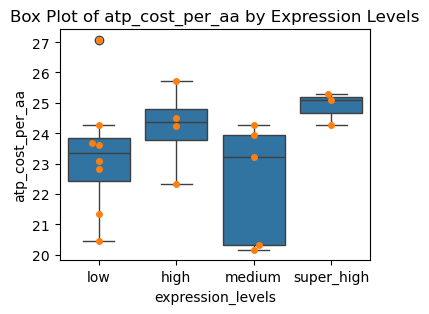

dna_complexity_per_aa


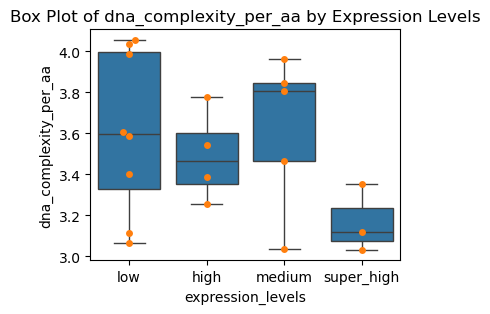

pll


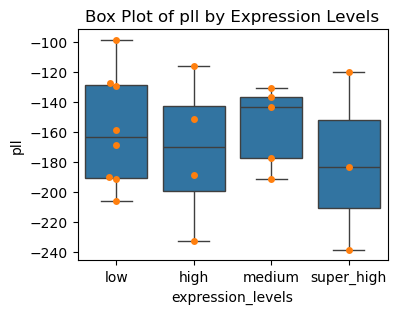

pll_per_aa


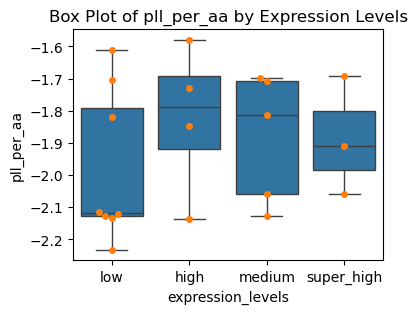

isoelectric_point


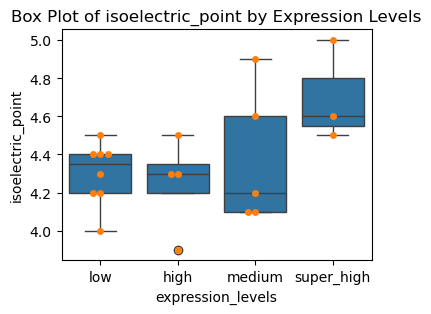

charge


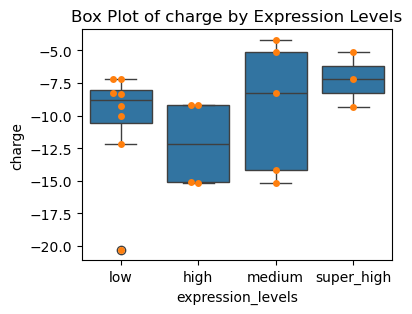

sequence_charge


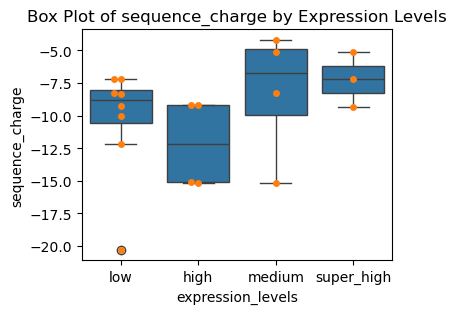

mass


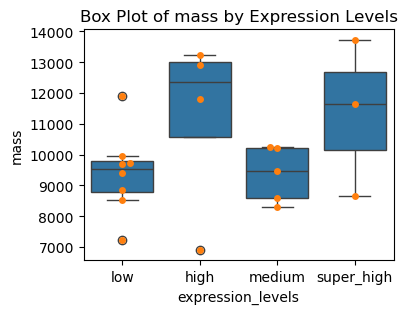

sequence_length


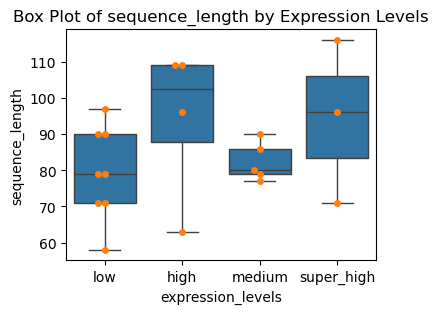

mean_plddt


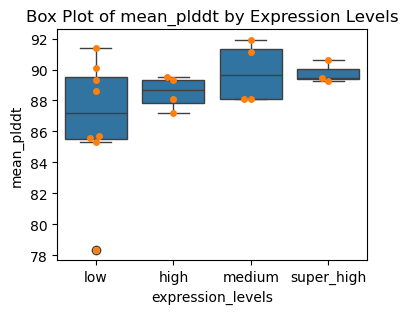

mean_pae


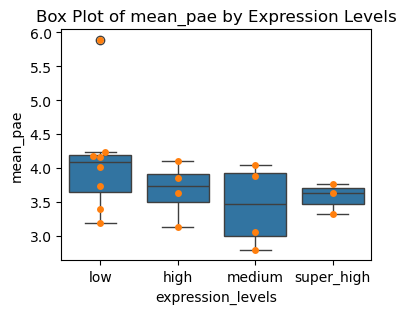

ptm


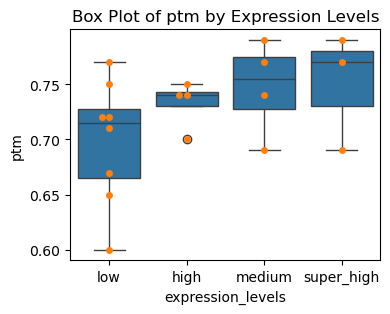

tm_rmsd


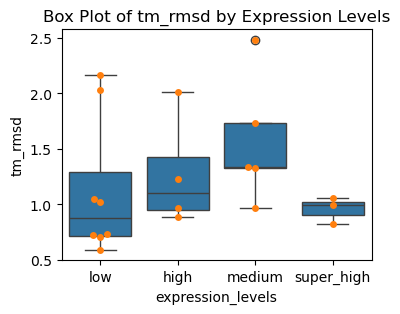

tm_score_assembly


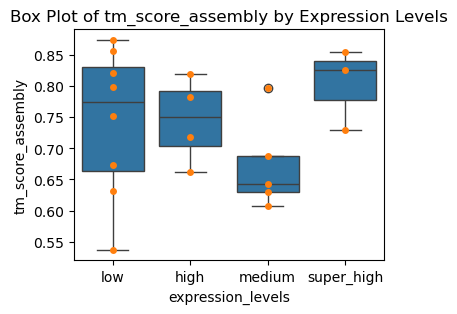

tm_score_design


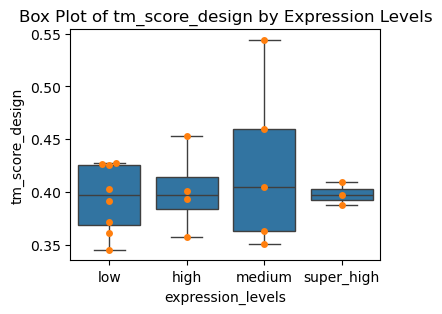

tm_rmsd100


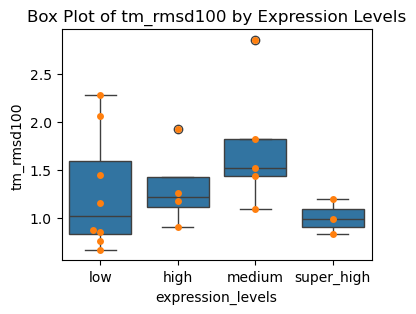

dp_finder_total_cost_norm


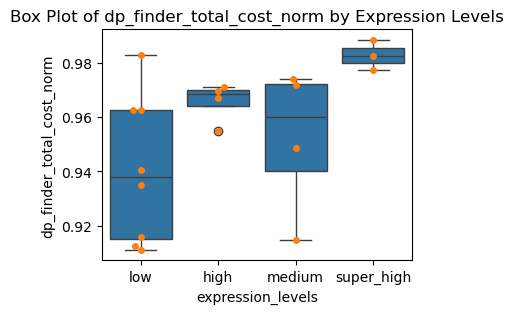

predicted_usability


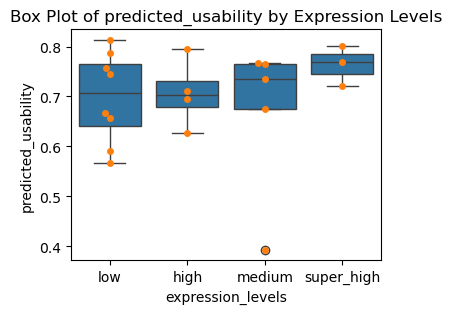

combined_score


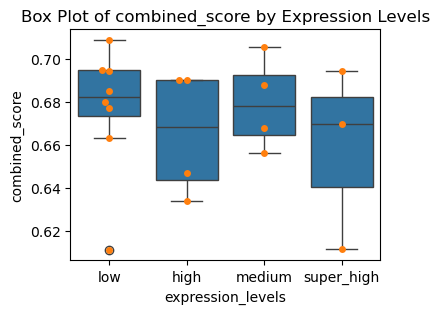

path_score_version


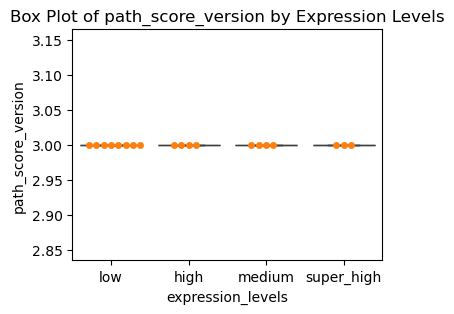

residues_per_helix


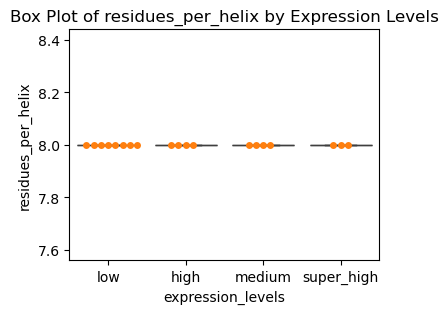

deltahedron_edge_length


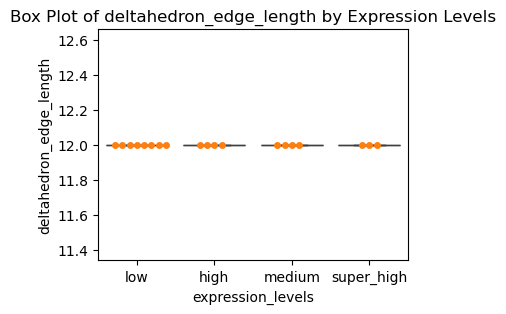

rf_file_num


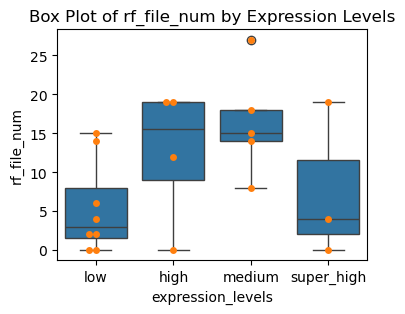

rib_num


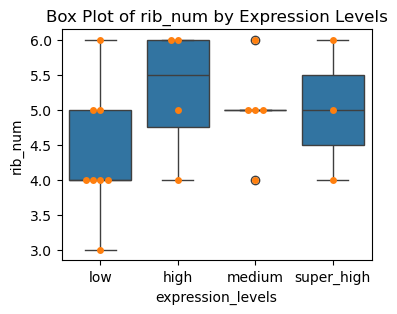

aa_count_per_gap


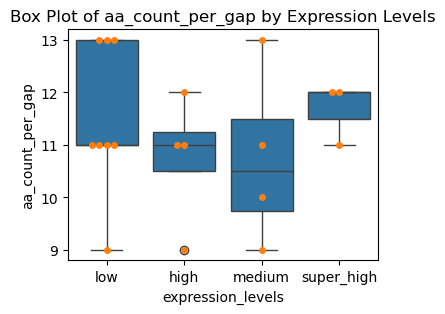

sequence_molar_extinction_280


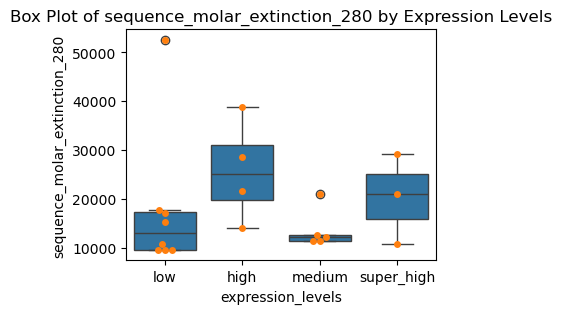

sequence_molecular_weight


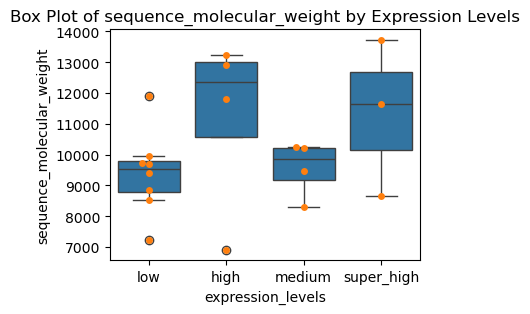

aligned_length


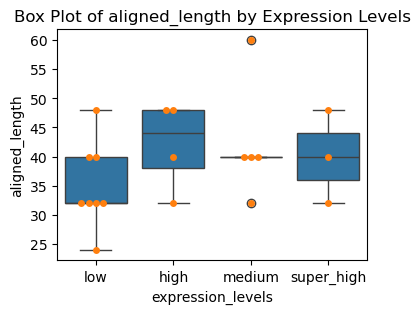

seq_id


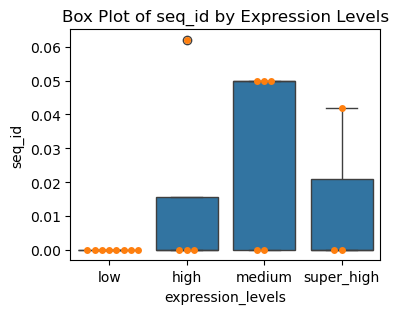

aggrescan3d_avg_value


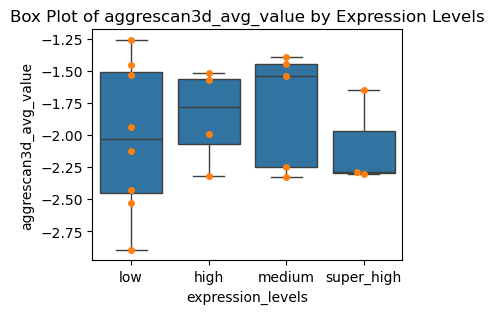

hydrophobic_fitness


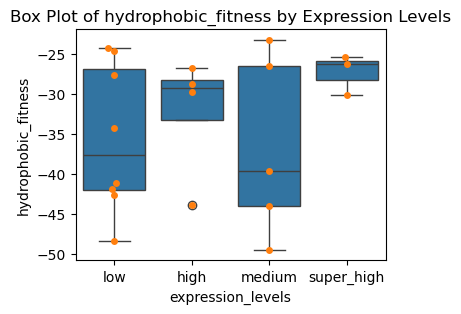

packing_density


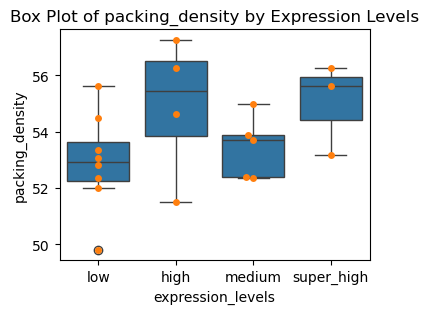

rosetta_total_per_aa


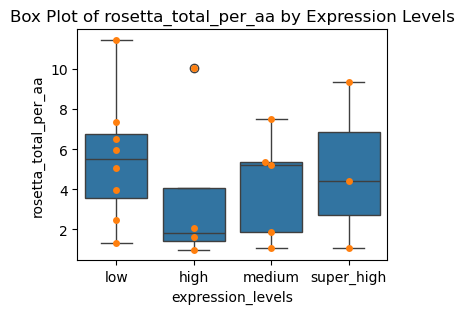

mass_w_prefix


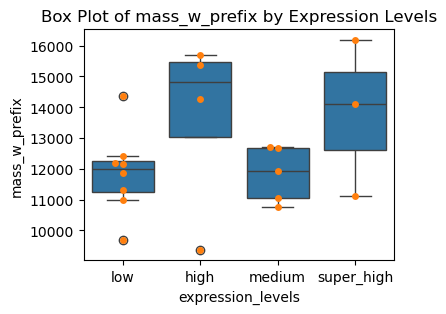

A280_after_NI_NTA_IMAC


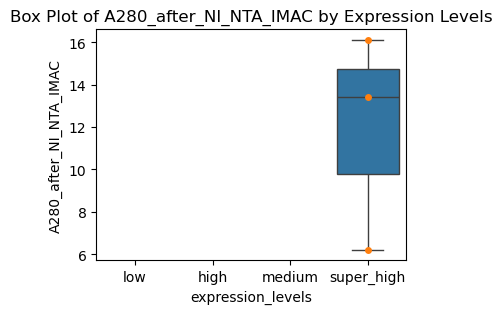

molar_conc_after_NI_NTA_IMAC


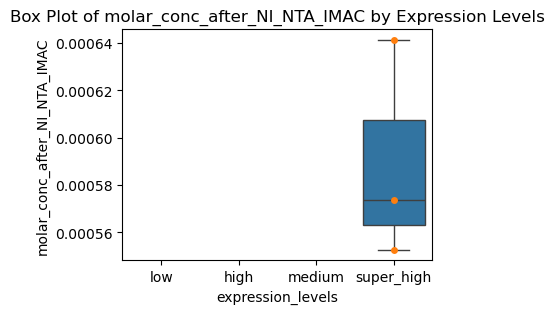

mg_per_ml_after_NI_NTA_IMAC


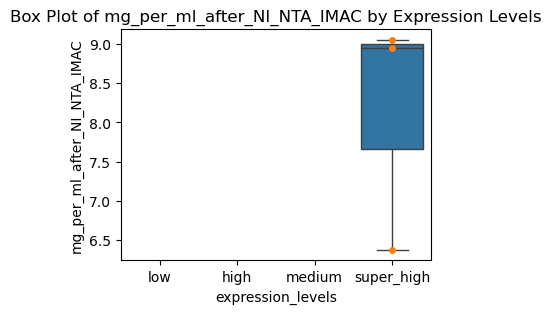

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it includes a categorical 'expression_levels'
# Identify all numeric columns in the dataframe
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# 1. Box Plots for each numeric feature
for col in numeric_columns:
    print(col)
    plt.figure(figsize=(4,3))
    sns.boxplot(x='expression_levels', y=col, data=df)
    sns.swarmplot(x='expression_levels', y=col, data=df)
    plt.title(f'Box Plot of {col} by Expression Levels')
    plt.show()

# # 2. Violin Plots for each numeric feature
# for col in numeric_columns:
#     plt.figure(figsize=(6,4))
#     sns.violinplot(x='expression_levels', y=col, data=df)
#     plt.title(f'Violin Plot of {col} by Expression Levels')
#     plt.show()

# # 3. Scatter Plot Matrix (Pairplot)
# sns.pairplot(df, hue='expression_levels', vars=numeric_columns)
# plt.show()

# # 4. Faceted Histograms using seaborn's FacetGrid for one numeric feature example:
# g = sns.FacetGrid(df, col="expression_levels", col_wrap=4, height=3)
# g.map(plt.hist, numeric_columns[0], bins=20)
# plt.show()
